In [1]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import awkward as ak

In [2]:
import uproot
### Energy = 0.15 GeV
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_v11.root")

tree = root_file["Samples"]
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])


print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]

labels = np.concatenate([y_real,y_noise])


# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

[[ 0.06895913  0.1056133  -0.09143379 ... -0.42161528 -0.29712962
  -0.58216445]
 [ 0.34485138 -0.08731802  0.06661344 ...  0.77302449  0.04550623
   0.00307311]
 [ 0.1237994   0.15758994  0.23702709 ...  0.74946809  0.89637208
   1.        ]
 ...
 [-0.03092482  0.05597267  0.02970392 ...  0.63602553  0.47977004
   0.197776  ]
 [-0.07213616  0.50158804  0.37323287 ...  0.94731449  1.
   0.95559548]
 [ 0.093267   -0.1169253  -0.21280756 ...  0.9604724   1.
   0.49827842]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [3]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
train_data = data[:train_size]
train_labels = labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')

number of rows in data is 200000
number of rows in data is 11
Size of training data is 140000
number of elements in data : training data : test data : 200000 : 140000 : 60000


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [9]:
train_data[0]

array([[ 0.18512114],
       [-0.20890033],
       [-0.70868399],
       [-1.        ],
       [-0.66414077],
       [ 0.01876789],
       [ 0.62579348],
       [ 0.45956214],
       [-0.12863019],
       [-0.56459289],
       [-0.58474894]])

In [7]:
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))

In [8]:
train_data[0]

array([[ 0.18512114],
       [-0.20890033],
       [-0.70868399],
       [-1.        ],
       [-0.66414077],
       [ 0.01876789],
       [ 0.62579348],
       [ 0.45956214],
       [-0.12863019],
       [-0.56459289],
       [-0.58474894]])

In [7]:
train_data = torch.tensor(train_data, dtype =torch.float).to(device)
test_data = torch.tensor(test_data, dtype =torch.float).to(device)
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)

In [8]:
test_labels.dtype

torch.float32

In [9]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        lebel: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data = data
        self.lebel = lebel

        print("data size = {}".format(data.size()))
        print("target size = {}".format(lebel.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data = self.data[index]
        lebel = self.lebel[index]
        return data, lebel

In [10]:
training_class = ClassifierDataset(
    data = train_data,
    lebel = train_labels)

data size = torch.Size([140000, 11, 1])
target size = torch.Size([140000, 1])


In [11]:
testing_class = ClassifierDataset(
    data = test_data,
    lebel = test_labels)

data size = torch.Size([60000, 11, 1])
target size = torch.Size([60000, 1])


In [13]:
class PositionalEncoder(nn.Module):

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=11, 
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            
            pe[0, :, 0::2] = torch.sin(position * div_term)
            
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
        
            pe[:, 0, 0::2] = torch.sin(position * div_term)
        
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [14]:
class TimeSeriesClassifier(nn.Module):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 .
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len


        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=input_size
            )
        
        self.final_linear_mapping = nn.Linear(
            in_features=dec_seq_len, 
            out_features=input_size
            )
        
        self.output = nn.Sigmoid()
        
        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # Creating the encoder layer 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
 
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        
        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder

        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))
        
        # Pass through linear mapping
        linear_output = self.linear_mapping(src) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after linear_mapping = {}".format(linear_output.size()))
        
        linear_output = linear_output.squeeze(-1)
        #print("From model.forward(): output size after unsqeeze = {}".format(linear_output.size()))
        
        # Pass through linear mapping
        final_linear_output = self.final_linear_mapping(linear_output) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after final linear_mapping = {}".format(final_linear_output.size()))
        
        # Final output
        final_output = self.output(final_linear_output)
        #print("From model.forward(): final output size = {}".format(final_output.size()))
        
        return final_output

In [15]:
## Params
dim_val = 512
n_heads = 8
n_encoder_layers = 4
dec_seq_len = 11 # length of input given to decoder
enc_seq_len = 11 # length of input given to encoder
in_features_encoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = True
epochs = 5
batch_size=100

classifier_model = TimeSeriesClassifier(
                input_size=1,
                dec_seq_len=enc_seq_len,
                batch_first=batch_first
                )

classifier_model = classifier_model.to(device)

optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

# Load the training data
training_dataloader = DataLoader(training_class, batch_size= batch_size)
# Load the testing data
testing_dataloader = DataLoader(testing_class, batch_size= batch_size)


# training prediction
training_truple = ()
training_truple_labels = ()
# testing prediction
testing_truple = ()
testing_truple_labels = ()

# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (data, labels) in enumerate(training_dataloader):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Permute from shape [batch size, seq len, num features] to [seq len, batch size, num features]
        if batch_first == False:

            shape_before = data.shape
            data = data.permute(1, 0, 2)
            print("src shape changed from {} to {}".format(shape_before, data.shape))

            shape_before = labels.shape
            labels = labels.permute(1, 0)
            print("src shape changed from {} to {}".format(shape_before, labels.shape))

        # make prediction
        prediction = classifier_model(
            src=data
            )
        #print(prediction)
        #print(labels)
        
        # Compute and backprop loss
        loss = criterion(prediction, labels)

        loss.backward()

        # Take optimizer step
        optimizer.step()
        
        if (i%100 == 0):
            print(f'training_loss: {loss}')
            
        if (epoch == epochs-1):
                training_truple += (prediction, )
                training_truple_labels +=(labels, )
        
    print(f' epoch:{epoch}    training_loss: {loss}')
        
    # Iterate over all (x,y) pairs in validation dataloader
    classifier_model.eval()
    
    with torch.no_grad():
    
        for j, (data_, labels_) in enumerate(testing_dataloader):

            prediction = classifier_model(
                src=data_
            )
            loss = criterion(prediction, labels_)
            if (j%100 == 0):
                print(f'testing_loss: {loss}')
            if (epoch == epochs-1):
                testing_truple += (prediction, )
                testing_truple_labels +=(labels_, )
                
    print(f' epoch:{epoch}    testing_loss: {loss}')
    

training_loss: 0.685576319694519
training_loss: 0.564555823802948
training_loss: 0.4867682158946991
training_loss: 0.608303964138031
training_loss: 0.4735959470272064
training_loss: 0.5465467572212219
training_loss: 0.610694408416748
training_loss: 0.4964722692966461
training_loss: 0.5699364542961121
training_loss: 0.5232754349708557
training_loss: 0.5453720688819885
training_loss: 0.4630308449268341
training_loss: 0.5121908187866211
training_loss: 0.5647201538085938
 epoch:0    training_loss: 0.4564690589904785
testing_loss: 0.4984474778175354
testing_loss: 0.49155256152153015
testing_loss: 0.5108937621116638
testing_loss: 0.5912500619888306
testing_loss: 0.5726398825645447
testing_loss: 0.6444536447525024
 epoch:0    testing_loss: 0.5417424440383911
training_loss: 0.4115756154060364
training_loss: 0.4879128038883209
training_loss: 0.4785189628601074
training_loss: 0.5496655702590942
training_loss: 0.4446903169155121
training_loss: 0.5481194257736206
training_loss: 0.5930203795433044


In [16]:
testing_hat = torch.cat(testing_truple)
testing_hat.size()

torch.Size([60000, 1])

In [17]:
testing_org = torch.cat(testing_truple_labels)
testing_org.size()

torch.Size([60000, 1])

In [18]:
y_test = testing_org.data.cpu().numpy()

In [19]:
predictions = testing_hat.data.cpu().numpy()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [1. 0. 0. ... 1. 1. 1.]
[[0.37720475]
 [0.14398283]
 [0.5136259 ]
 ...
 [0.27967367]
 [0.04657919]
 [0.6846056 ]]
[[0.2841622 ]
 [0.411312  ]
 [0.6034487 ]
 ...
 [0.6869171 ]
 [0.27580103]
 [0.27540877]]


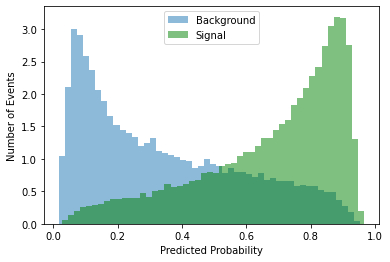

In [21]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
plt.show()

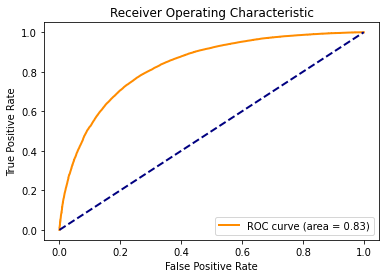

In [22]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.show()

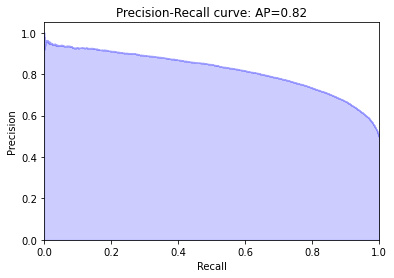

In [23]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [36]:
binary_prediction = predictions > 0.5

In [37]:
y_test.shape

(60000, 1)

In [38]:
np.count_nonzero(binary_prediction == y_test)

45416